In [27]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.cuda.amp import autocast, GradScaler

import torchvision.models as models
from torchvision import transforms, datasets
from torchvision.io import read_image
from torchvision.models import inception_v3, Inception_V3_Weights

from sklearn.metrics import classification_report, confusion_matrix

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [28]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ChestScans

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ChestScans


In [29]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        # Load pretrained EfficientNetB0
        self.base_model = models.efficientnet_b0(pretrained=True)

        # Global Average Pooling after features
        self.pool = nn.AdaptiveAvgPool2d(1)

        # Custom dense blocks
        self.fc1 = nn.Linear(1280, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.3)

        self.output_layer = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)  # EfficientNet features
        x = self.pool(x)                 # Global Average Pooling
        x = torch.flatten(x, 1)

        x = F.leaky_relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.leaky_relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.output_layer(x)
        return x  # Raw logits (apply softmax during evaluation if needed)

In [30]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-7, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_state = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.restore_best_weights:
                self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights and self.best_model_state:
                    model.load_state_dict(self.best_model_state)

In [31]:
def compile_and_prepare_model(model):
    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss function (for 3-class classification)
    criterion = nn.CrossEntropyLoss()

    # Optimizer with weight decay (AdamW)
    initial_learning_rate = 0.0005
    optimizer = optim.AdamW(model.parameters(), lr=initial_learning_rate, weight_decay=0.01)

    # Learning rate scheduler (Exponential decay)
    decay_rate = 0.9
    decay_steps = 1000

    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=3,       # Number of epochs before the first restart
        T_mult=2,     # Multiply T_0 by this factor after each restart
        eta_min=1e-6  # Minimum learning rate
    )

    return model, criterion, optimizer, scheduler, device


In [32]:
def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, scheduler, early_stopping, num_epochs=60):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        # Logging
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

        torch.save(model.state_dict(), "last_full_model.pth")
        # Callbacks (ReduceLROnPlateau and EarlyStopping)
        scheduler.step(epoch)
        early_stopping(avg_val_loss, model)

        if avg_val_loss <= early_stopping.best_loss:
            torch.save(model.state_dict(), "best_full_model.pth")
            print("Model checkpoint saved.")

        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    return history

In [33]:
def evaluate_model(model, test_loader, loss_fn, history, class_names=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    # Initialize variables
    test_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    # No gradients are needed during evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item() * labels.size(0)

            # Predictions and accuracy calculation
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    # Average test loss and accuracy
    avg_test_loss = test_loss # / total
    test_accuracy = correct / total

    # Print test results
    print("\nTest Results:")
    print(f"Loss: {avg_test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    if class_names:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

    # Classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)

    if(history):
        # Plot train and validation loss curves
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.legend()
        plt.title('Loss Curves')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
    plt.show()

    return avg_test_loss, test_accuracy, cm, report

In [34]:
data_transforms = transforms.Compose([
    transforms.Resize((299, 299)),         # Resize to 299x299 pixels
    transforms.ToTensor(),                 # Convert to tensor
])

dataset = datasets.ImageFolder("./data", transform=data_transforms)
train_set, val_set, test_set = random_split(dataset, [0.7, 0.15, 0.15])

In [35]:
BATCH_SIZE = 128
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=12,
    pin_memory=True
)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=12,
    pin_memory=True
)
val_loader = DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=12,
    pin_memory=True
)

In [36]:
model = CNN(num_classes=7)
model, criterion, optimizer, scheduler, device = compile_and_prepare_model(model)

early_stopping = EarlyStopping(patience=10, min_delta=1e-7, restore_best_weights=True)

history = train_and_validate(model, train_loader, val_loader, optimizer, criterion, scheduler, early_stopping, num_epochs=100)


Epoch 1/100
Train Loss: 1.3162, Acc: 0.4832 | Val Loss: 1.1227, Acc: 0.5714
Model checkpoint saved.

Epoch 2/100
Train Loss: 1.0379, Acc: 0.6086 | Val Loss: 1.0105, Acc: 0.6138
Model checkpoint saved.

Epoch 3/100
Train Loss: 0.8157, Acc: 0.6971 | Val Loss: 0.9675, Acc: 0.6484
Model checkpoint saved.

Epoch 4/100
Train Loss: 0.5095, Acc: 0.8171 | Val Loss: 0.7560, Acc: 0.7333
Model checkpoint saved.

Epoch 5/100
Train Loss: 0.6280, Acc: 0.7706 | Val Loss: 0.8498, Acc: 0.6937

Epoch 6/100
Train Loss: 0.4477, Acc: 0.8396 | Val Loss: 0.9100, Acc: 0.6893

Epoch 7/100
Train Loss: 0.3018, Acc: 0.8939 | Val Loss: 0.8217, Acc: 0.7331

Epoch 8/100
Train Loss: 0.1702, Acc: 0.9405 | Val Loss: 0.7600, Acc: 0.7753

Epoch 9/100
Train Loss: 0.0931, Acc: 0.9694 | Val Loss: 0.7116, Acc: 0.7964
Model checkpoint saved.

Epoch 10/100
Train Loss: 0.0566, Acc: 0.9831 | Val Loss: 0.7041, Acc: 0.8038
Model checkpoint saved.

Epoch 11/100
Train Loss: 0.2845, Acc: 0.8994 | Val Loss: 0.8754, Acc: 0.7232

Epoch 


Test Results:
Loss: 3792.3812
Accuracy: 0.8173


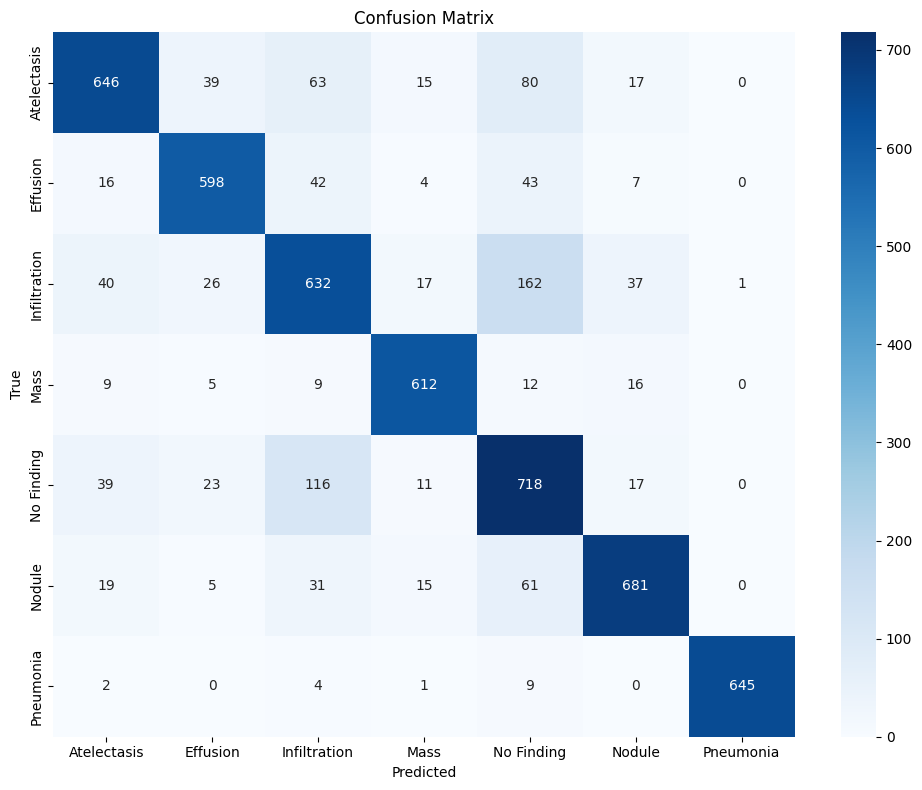


Classification Report:
              precision    recall  f1-score   support

 Atelectasis     0.8379    0.7512    0.7922       860
    Effusion     0.8592    0.8423    0.8506       710
Infiltration     0.7046    0.6907    0.6976       915
        Mass     0.9067    0.9231    0.9148       663
  No Finding     0.6618    0.7771    0.7148       924
      Nodule     0.8787    0.8387    0.8582       812
   Pneumonia     0.9985    0.9758    0.9870       661

    accuracy                         0.8173      5545
   macro avg     0.8353    0.8284    0.8307      5545
weighted avg     0.8226    0.8173    0.8187      5545



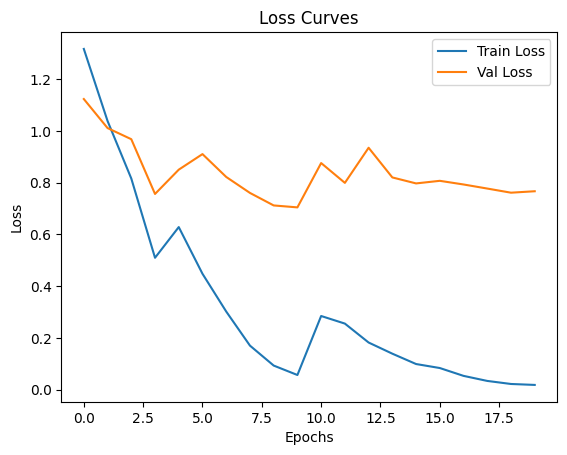

In [37]:
class_names = [
    'Atelectasis',
    'Effusion',
    'Infiltration',
    'Mass',
    'No Finding',
    'Nodule',
    'Pneumonia',
]

avg_test_loss, test_accuracy, cm, report = evaluate_model(model, test_loader, criterion, history, class_names)